# Analysis of DR9 QSO

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd

import modules as md
import sys
sys.path.append('/Users/rezaie/github/LSSutils')
from lssutils.lab import (hpixsum, AnaFast, get_shotnoise,
                          make_overdensity, histogram_cell)
from lssutils.dataviz import setup_color
from time import time

In [2]:
setup_color()

In [3]:
nside = 512
dat_path = '/Volumes/TimeMachine/data/DR9fnl/FOR_MEDHI/Catalogs/north_targets-final.txt'
ran_path = '/Volumes/TimeMachine/data/DR9fnl/FOR_MEDHI/Catalogs/north_randoms.txt'
tem_path = '/Volumes/TimeMachine/data/templates/dr9/dr9m_nside512.h5'

t0 = time()
dat = np.loadtxt(dat_path)
ran = np.loadtxt(ran_path)
t1 = time()
print(f'Read the input catalogs in {t1-t0:.1f} secs')

dathp = hpixsum(nside, dat[:, 0], dat[:, 1], weights=dat[:, -1])
ranhp = hpixsum(nside, ran[:, 0], ran[:, 1], weights=ran[:, -1])
t2 = time()
print(f'Project data and randoms to hp in {t2-t1:.1f} secs')

mask = ranhp > 0.0
frac = np.zeros_like(ranhp)
frac[mask] = ranhp[mask] / ranhp[mask].mean()
t3 = time()
print(f'Compute pixel completeness in {t3-t2:.1f} secs')

tmpl = pd.read_hdf(tem_path)
t4 = time()
print(f'Read imaging maps in {t4-t3:.1f} secs')

Read the input catalogs in 100.3 secs
Project data and randoms to hp in 0.9 secs
Compute pixel completeness in 0.0 secs
Read imaging maps in 8.3 secs


In [4]:
tmpl.columns

Index(['airmass_mean_g', 'ccdskymag_mean_g', 'exptime_total_g', 'fwhm_max_g',
       'fwhm_mean_g', 'fwhm_min_g', 'depth_total_g', 'mjd_max_g', 'mjd_mean_g',
       'mjd_min_g', 'nobs_fracdet_g', 'nobs_total_g', 'airmass_mean_r',
       'ccdskymag_mean_r', 'exptime_total_r', 'fwhm_max_r', 'fwhm_mean_r',
       'fwhm_min_r', 'depth_total_r', 'mjd_max_r', 'mjd_mean_r', 'mjd_min_r',
       'nobs_fracdet_r', 'nobs_total_r', 'airmass_mean_z', 'ccdskymag_mean_z',
       'exptime_total_z', 'fwhm_max_z', 'fwhm_mean_z', 'fwhm_min_z',
       'depth_total_z', 'mjd_max_z', 'mjd_mean_z', 'mjd_min_z',
       'nobs_fracdet_z', 'nobs_total_z', 'nstar', 'ebv', 'loghi'],
      dtype='object')

In [7]:
columns = ['nstar', 'ebv', 'loghi']\
          +[f'{s}_{b}' for s in ['ccdskymag_mean', 'fwhm_mean', 'depth_total', 
                                'mjd_min', 'airmass_mean', 'exptime_total']\
                      for b in ['g', 'r', 'z']]

tmpl_np = tmpl[columns].values

mask_t = mask.copy()
for i in range(tmpl_np.shape[1]):
    mask_t &= np.isfinite(tmpl_np[:, i])
print(f'before: {mask.sum()}, after: {mask_t.sum()}')

before: 394115, after: 392288


In [8]:
def to_numpy(label, features, frac, hpix):

    dtype = [('features', ('f8', features.shape[1])), 
             ('label', 'f8'),
             ('fracgood', 'f8'),
             ('hpix', 'i8')]    

    d = np.zeros(label.size, dtype=dtype)
    
    d['label'] = label
    d['fracgood'] = frac
    d['features'] = features
    d['hpix'] = hpix

    return d    

In [9]:
d = to_numpy(dathp[mask_t], tmpl_np[mask_t], frac[mask_t], np.argwhere(mask_t).flatten())

In [10]:
import fitsio as ft

In [11]:
tab_path = '/Volumes/TimeMachine/data/DR9fnl/qso/regression/bass/nqso_bass_512.fits'
ft.write(tab_path, d)

In [12]:
np.percentile((dathp/frac)[mask], [1, 99])

<ipython-input-12-9c767557b412>:1: RuntimeWarning: divide by zero encountered in true_divide
  np.percentile((dathp/frac)[mask], [1, 99])
<ipython-input-12-9c767557b412>:1: RuntimeWarning: invalid value encountered in true_divide
  np.percentile((dathp/frac)[mask], [1, 99])


array([ 0.        , 11.62197732])

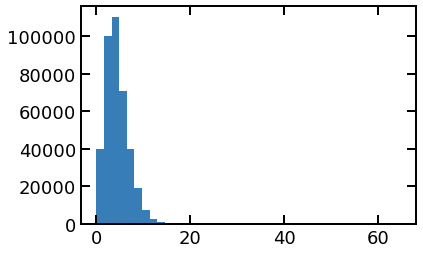

In [18]:
_ = plt.hist(dathp[mask_t]/frac[mask_t], bins=40)

In [28]:
d_ = ft.read('/Volumes/TimeMachine/data/DR9fnl/qso/regression/bass/nn_mse/nn-weights.fits')

wnn = np.zeros_like(dathp)
wnn[d_['hpix']] = d_['weight']

In [37]:
norm_factor = (dathp/wnn)[mask_t].sum()/dathp[mask_t].sum()
wnn_norm = wnn*norm_factor

<ipython-input-37-343ba2707967>:1: RuntimeWarning: divide by zero encountered in true_divide
  norm_factor = (dathp/wnn)[mask_t].sum()/dathp[mask_t].sum()
<ipython-input-37-343ba2707967>:1: RuntimeWarning: invalid value encountered in true_divide
  norm_factor = (dathp/wnn)[mask_t].sum()/dathp[mask_t].sum()


In [42]:
np.percentile(wnn_norm[mask_t].clip(0.5, 2.0), [0, 100])

array([0.5       , 1.23769636])

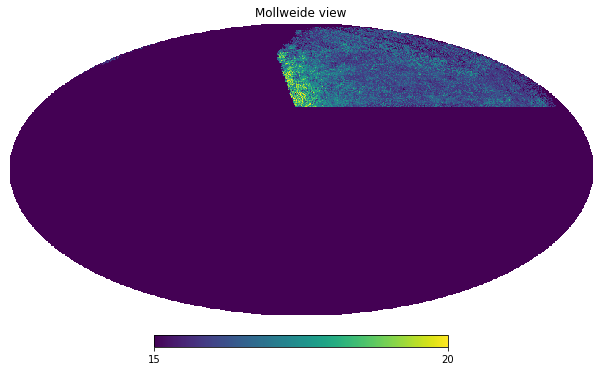

In [31]:
hp.mollview(wnn, rot=-85, min=15, max=20)

In [48]:
delta_null = make_overdensity(dathp, frac, mask_t)

In [44]:
delta_nn = make_overdensity(dathp, frac, mask_t, selection_fn=wnn_norm.clip(0.5, 2.0))

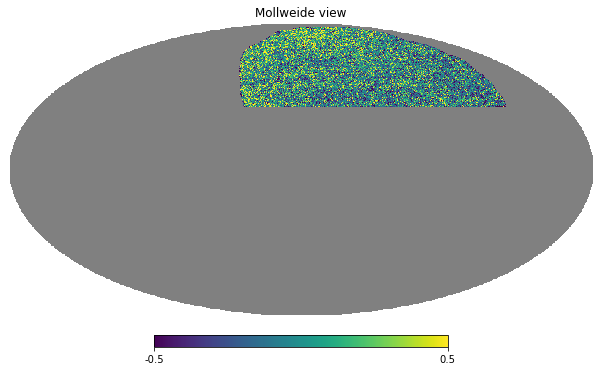

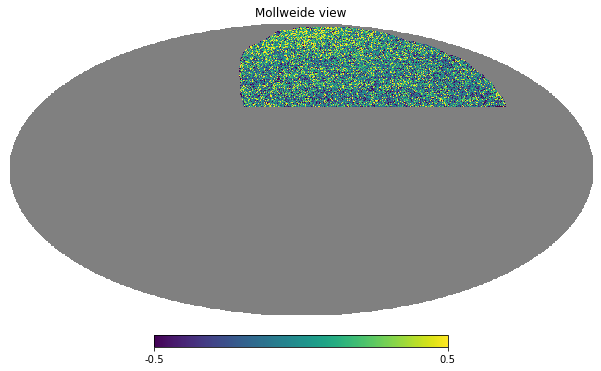

In [52]:
hp.mollview(delta_null, rot=-120, min=-0.5, max=0.5)
hp.mollview(delta_nn, rot=-120, min=-0.5, max=0.5)

<ipython-input-26-5b333b37d449>:1: RuntimeWarning: invalid value encountered in true_divide
  hp.mollview(dathp/frac, rot=-85, min=10, max=30)


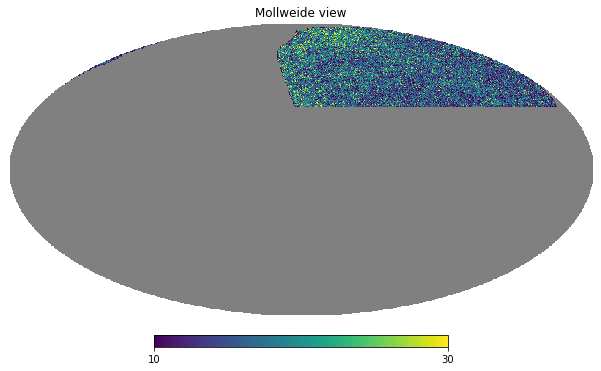

In [26]:
hp.mollview(dathp/frac, rot=-85, min=10, max=30)

# n(z)

In [ ]:
nz = md.NoZ('/Volumes/TimeMachine/data/DR9fnl/FOR_MEDHI/RF_g.txt', fill_value=0.0)
z_g = np.arange(0.0, 5.0, 0.01)
np.savetxt('/Volumes/TimeMachine/data/DR9fnl/nz_qso_rf.txt',
          np.column_stack([z_g, nz.nz_fn(z_g)]),
          header='z -- n(z)')


plt.step(nz.z_, nz.nz_/nz.nz_norm, where='mid', lw=1, color='grey')
plt.plot(z_g, nz.nz_fn(z_g), 'b--', label='n(z)')
plt.legend()
plt.xlabel('z')
plt.ylabel('n(z)')

# Mask, Galaxy, and Randoms

In [8]:
# data
g = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/FOR_MEDHI/Catalogs/north_targets-final.txt')
gc = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/FOR_MEDHI/Catalogs/north_targets-final_corrected.txt')

# randoms
r = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/FOR_MEDHI/Catalogs/north_randoms.txt')

In [9]:
hp_r = hpixsum(256, r[:, 0], r[:, 1], weights=r[:, -1])
hp_r512 = hpixsum(512, r[:, 0], r[:, 1], weights=r[:, -1])

hp_g = hpixsum(256, g[:, 0], g[:, 1], weights=g[:, -1])
hp_gc = hpixsum(256, gc[:, 0], gc[:, 1], weights=gc[:, -1])

mask = hp_r > 0.0

In [10]:
frac = hp_r / hp_r[mask].mean()
get_shotnoise(hp_gc, frac, mask)

1.0173709503964513e-06

In [11]:
np.percentile(hp_gc[mask], [1, 99])

array([ 6.17444922, 26.9184522 ])

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


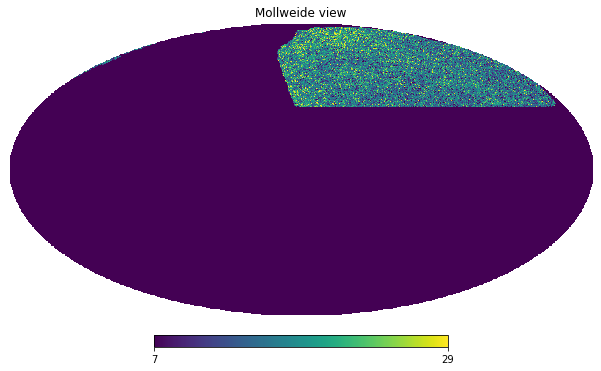

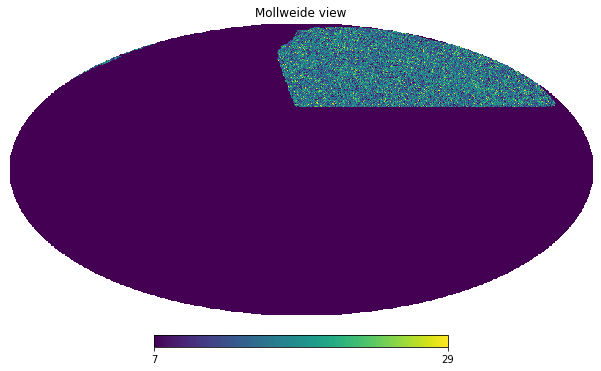

In [39]:
hp.mollview(hp_g, rot=-85, min=7, max=29)
hp.mollview(hp_gc, rot=-85, min=7, max=29)

In [12]:
delta = make_overdensity(hp_g, hp_r, mask)
delta_c = make_overdensity(hp_gc, hp_r, mask)

In [13]:
af = AnaFast()
cl = af.run(delta, frac, mask)
cl_c = af.run(delta_c, frac, mask)

<ipython-input-14-f9b892c85450>:11: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(2.0e-7, 2.0-3)


(2e-07, 0.00416212115277246)

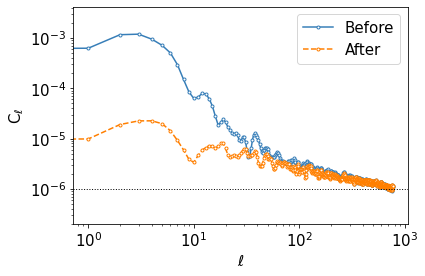

In [14]:
plt.plot(cl, marker='.', mfc='w')
plt.plot(cl_c, marker='.', mfc='w', ls='--')
plt.legend(['Before', 'After'])

plt.axhline(1.0173709503964513e-06, lw=1, color='k', ls=':')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
plt.ylim(2.0e-7, 2.0-3)

In [15]:
np.savez('/Volumes/TimeMachine/data/DR9fnl/cl_qso_north_rf.npz', **{'cl_before':cl, 'cl_after':cl_c})
hp.write_map('/Volumes/TimeMachine/data/DR9fnl/north_mask_hp256.hp.fits', 
             hp_r, dtype='float64', fits_IDL=False, overwrite=True)
hp.write_map('/Volumes/TimeMachine/data/DR9fnl/north_mask_hp512.hp.fits', 
             hp_r512, dtype='float64', fits_IDL=False, overwrite=True)

In [16]:
import pandas as pd

In [8]:
ls /Volumes/TimeMachine/data/

FOR_MEDHI/                gaussian_mocks/           nz_qso_rf.txt
cl_qso_north_rf.npz       north_mask_hp256.hp.fits  nz_qso_rfv2.txt
cl_true_fnl0.txt          north_mask_hp512.hp.fits


In [29]:
tmpl = pd.read_hdf('/Volumes/TimeMachine/data/templates/dr9/dr9_combined256.h5')
tmpl.head()

,airmass_g_mean,ccdskymag_g_mean,exptime_g_total,fwhm_g_max,fwhm_g_mean,fwhm_g_min,hits_g_fracdet,hits_g_total,depth_g_total,mjd_g_max,...,fwhm_z_min,hits_z_fracdet,hits_z_total,depth_z_total,mjd_z_max,mjd_z_mean,mjd_z_min,nstar,ebv,loghi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.999997,0.262538,20.807163
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.000002,0.259362,20.794398
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.000002,0.220059,20.776257
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.999999,0.222648,20.786459
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.000001,0.335517,20.811402


In [30]:
from lssutils.stats.nnbar import MeanDensity

In [31]:
nbar = MeanDensity(hp_g, hp_r, mask, tmpl['ebv'].values)
nbar.run()

In [32]:
nbarc = MeanDensity(hp_gc, hp_r, mask, tmpl['ebv'].values)
nbarc.run()

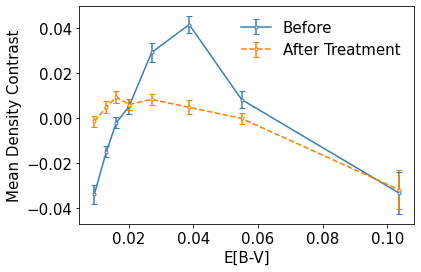

In [40]:
for nbar_i in [nbar, nbarc]:
    plt.errorbar(nbar_i.output['bin_avg'], nbar_i.output['nnbar']-1,
                 yerr=nbar_i.output['nnbar_err'], capsize=3, marker='.', mfc='w')
plt.legend(['Before', 'After Treatment'], frameon=False)
plt.ylabel('Mean Density Contrast')
plt.xlabel('E[B-V]')
plt.savefig('nbar_ebv.png', dpi=300, bbox_inches='tight')

In [41]:
from lssutils.stats.pcc import pcc

In [42]:
tmpl.columns

Index(['airmass_g_mean', 'ccdskymag_g_mean', 'exptime_g_total', 'fwhm_g_max',
       'fwhm_g_mean', 'fwhm_g_min', 'hits_g_fracdet', 'hits_g_total',
       'depth_g_total', 'mjd_g_max', 'mjd_g_mean', 'mjd_g_min',
       'airmass_r_mean', 'ccdskymag_r_mean', 'exptime_r_total', 'fwhm_r_max',
       'fwhm_r_mean', 'fwhm_r_min', 'hits_r_fracdet', 'hits_r_total',
       'depth_r_total', 'mjd_r_max', 'mjd_r_mean', 'mjd_r_min',
       'airmass_z_mean', 'ccdskymag_z_mean', 'exptime_z_total', 'fwhm_z_max',
       'fwhm_z_mean', 'fwhm_z_min', 'hits_z_fracdet', 'hits_z_total',
       'depth_z_total', 'mjd_z_max', 'mjd_z_mean', 'mjd_z_min', 'nstar', 'ebv',
       'loghi'],
      dtype='object')

In [47]:
tmpl_np = tmpl.values
tmpl_np.shape

(786432, 39)

In [48]:
mask_t = mask.copy()
print(mask_t.sum())
for i in range(39):
    mask_t &= np.isfinite(tmpl_np[:, i])
print(mask_t.sum())

98548
98173


In [49]:
columns = ['nstar', 'ebv', 'loghi', 'ccdskymag_g_mean', 'fwhm_g_mean', 'depth_g_total', 'mjd_g_min']
y = delta[mask_t]
xfeatures = tmpl[columns][mask_t].values
yc = delta_c[mask_t]
xfeatures.shape

(98173, 7)

In [50]:
pcc_bf = pcc(xfeatures, y, return_err=True)

In [51]:
pcc_af = pcc(xfeatures, yc, return_err=True)

In [61]:
np.array(pcc_af[1]).shape

(100, 7)

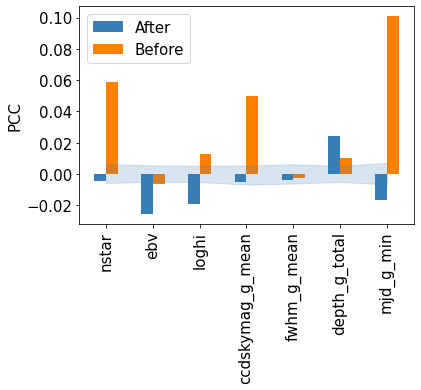

In [84]:
fg, ax = plt.subplots()

x_columns = np.arange(len(columns))
ax.set_xticks(x_columns)
ax.set_xticklabels(columns, rotation=90)

pcc_min, pcc_max = np.percentile(pcc_af[1], [2.5, 97.5], axis=0)

ax.bar(x_columns-0.125, pcc_af[0], color='C0', width=0.25, label='After')
ax.bar(x_columns+0.125, pcc_bf[0], color='C1', width=0.25, label='Before')
ax.fill_between(x_columns, pcc_min, pcc_max, color='C0', alpha=0.2, zorder=10)

ax.legend()
ax.set(ylabel='PCC')
fg.savefig('pcc_dr9bass.png', dpi=300, bbox_inches='tight')

In [27]:
ls -lt /Volumes/TimeMachine/data/templates/dr9/dr9_combined256

total 2242704
-rw-r--r--  1 rezaie  staff  100670536 Apr  9 14:58 dr9pub_nside256.h5
-rw-r--r--  1 rezaie  staff  251665480 Apr  9 14:57 dr9_combined256.h5
-rw-r--r--  1 rezaie  staff     881321 Apr  9 14:57 dr9_combined256.png
-rw-r--r--  1 rezaie  staff  795041280 Apr  9 14:57 ccds-annotated-combined-dr9-test.fits
drwxr-xr-x  3 rezaie  staff        102 Apr  9 13:38 DECaLS_dr9-combined/
drwxr-xr-x  3 rezaie  staff        102 Apr  9 13:38 dr9pub/


# Create Gaussian Mocks

In [9]:
cl_data = np.load('/Volumes/TimeMachine/data/DR9fnl/cl_qso_north_rf.npz', allow_pickle=True)
shotnoise = 1.017379567874895e-06
cl_obs = cl_data['cl_after']#-shotnoise
el_obs = np.arange(cl_obs.size)
elb, clb = histogram_cell(cl_obs, bins=np.arange(0, 700, 40.))

In [10]:
z, nz = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/nz_qso_rf.txt').T   # ext=0
b = np.ones_like(z)

In [11]:
ell = np.arange(1000)

cosmo = md.init_cosmology()
mod = md.PNGModel(cosmo, has_rsd=True, has_fnl=True)
mod.add_tracer(z, b, nz, p=1.6)

cl_true = mod(ell, fnl=0.0)

# np.savetxt('/Volumes/TimeMachine/data/DR9fnl/cl_true_fnl0.txt', cl_true)

NOTE: This code uses a cosmology calculator that returns k and P(k) in units of 1/Mpc and Mpc^3.
 Therefore, the coefficient alpha in the model uses H_0 = 100h, not H_0=100.
will create windows


Text(0, 0.5, 'C$_{\\ell}$')

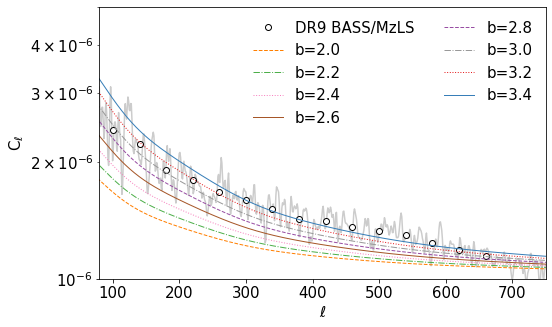

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(el_obs, cl_obs, color='k', alpha=0.2)
plt.plot(elb, clb, marker='o', color='k', mfc='w', ls='None', label='DR9 BASS/MzLS')

for b_i in np.arange(2.0, 3.6, 0.2):
    plt.plot(ell, b_i*b_i*cl_true+shotnoise, lw=1, label=f'b={b_i:.1f}')
    
plt.legend(frameon=False, ncol=2)    
plt.yscale('log')
# plt.ylim(8.0e-7, 5.0e-6)
plt.xlim(80, 750)
plt.ylim(1.0e-6, 5.0e-6)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')
# plt.savefig('dr9_bias.png', dpi=300, bbox_inches='tight')

# Create Mock Realizations

In [37]:
# read c_ell
cl_true = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/cl_true_fnl0.txt')

# read mask
mask = hp.read_map('/Volumes/TimeMachine/data/DR9fnl/north_mask_hp256.hp.fits', dtype=np.float64) > 0.0
maskf = np.ones_like(mask)
weight = maskf * 1.0                 # all sky is the same

/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [ ]:
# run once
cls = {'full':[], 'masked':[]}

nside = 256
nmocks = 2000

np.random.seed(42)
seeds = np.random.randint(0, 2**32-1, size=nmocks)

print(np.unique(seeds).size)
af = md.AnaFast()

i = 0
for seed in tqdm(seeds):
    
    np.random.seed(seed)
    map1 = hp.synfast(cl_true, nside, pol=False, )
    
    map_f = map1 - map1.mean()       # full sky
    map_p = map1 - map1[mask].mean()  # partial sky
    
    
    filename = f'/Volumes/TimeMachine/data/DR9fnl/gaussian_mocks/mock_{i:04d}.fits'
    #print(filename, map_f[maskf].mean(), map_p[mask].mean())

    hp.write_map(filename, map1, fits_IDL=False, overwrite=True, dtype='float64')
    
    cls['full'].append(af.run(map_f, weight, maskf))
    cls['masked'].append(af.run(map_p, weight, mask))
    
    i += 1
np.savez('./cl_mocks_2k_qso.npz', **cls)    

2000


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [15]:
cl_data = np.load('/Volumes/TimeMachine/data/DR9fnl/cl_qso_north_rf.npz', allow_pickle=True)
shotnoise = 1.017379567874895e-06

In [16]:
cl_obs = cl_data['cl_after']-shotnoise
el_obs = np.arange(cl_obs.size)
elb, clb = histogram_cell(cl_obs, bins=np.arange(0, 700, 40.))

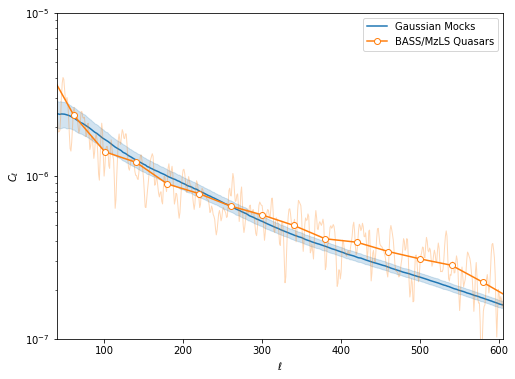

In [26]:
cl_mean = np.mean(cls['masked'], axis=0)
cl_min, cl_max = np.percentile(cls['masked'], [15.4, 84.6], axis=0)
el = np.arange(cl_min.size)


plt.figure(figsize=(8, 6))

# mocks
plt.plot(el, cl_mean, color='C0', label='Gaussian Mocks')
plt.fill_between(el, cl_min, cl_max, color='C0', alpha=0.2)

# plt.plot(cl_true, 'r--', zorder=5, label='Truth')

plt.plot(el_obs, cl_obs, color='C1', alpha=0.3, lw=1)
plt.plot(elb, clb, color='C1', marker='o', mfc='w', ls='-', label='BASS/MzLS Quasars')

plt.legend()
plt.xlim(40, 605)
plt.ylim(1.0e-7, 1.0e-5)
plt.yscale('log')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
# plt.xscale('log')
# plt.yscale('log')
plt.savefig('mocks_vs_data.png', dpi=300, bbox_inches='tight')